In [3]:
import numpy as np
import pandas as pd
import torch
import random
import time
import math
import csv
from PIL import Image
import io
import tqdm  # Fix: import module directly
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import wandb

# Show library versions
print("Library Versions:")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"torch: {torch.__version__}")
print(f"PIL (Pillow): {Image.__version__}")
print(f"tqdm: {tqdm.__version__}")  # Fixed
print(f"matplotlib: {matplotlib.__version__}")  # Fixed
print(f"wandb: {wandb.__version__}")

# Standard libraries (no version attribute, shown as 'builtin')
print("random: builtin")
print("time: builtin")
print("math: builtin")
print("csv: builtin")
print("io: builtin")
print("datetime: builtin")
print("copy: builtin")
print("collections: builtin")



wandb.login(key = '5df7feeffbc5b918c8947f5fe4bab4b67ebfbb69')


Library Versions:
numpy: 2.0.2
pandas: 2.2.3
torch: 2.7.0
PIL (Pillow): 11.2.1
tqdm: 4.67.1
matplotlib: 3.9.4
wandb: 0.19.11
random: builtin
time: builtin
math: builtin
csv: builtin
io: builtin
datetime: builtin
copy: builtin
collections: builtin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/indramandal/.netrc
wandb: Currently logged in as: ed24s014 (ed24s014-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

### Setting File Paths for Dataset
This cell defines the file paths for the training, development, and test datasets. The datasets are part of the Dakshina dataset and are stored locally in .tsv format. These paths are used for loading data for preprocessing and model training.

In [2]:
train_df =('/Users/indramandal/Documents/VS_CODE/DA6401/DA6401_Assignment_3/predictions_vanilla/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.train.tsv')
dev_df = ('/Users/indramandal/Documents/VS_CODE/DA6401/DA6401_Assignment_3/predictions_vanilla/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.dev.tsv')
test_df = ('/Users/indramandal/Documents/VS_CODE/DA6401/DA6401_Assignment_3/predictions_vanilla/dakshina_dataset_v1.0/bn/lexicons/bn.translit.sampled.test.tsv')

### Data Preprocessing Class for Sequence-to-Sequence Tasks
This cell defines a class SequenceDataPreprocessor that:

- Reads data from the provided file paths.
- Tokenizes input and target sequences.
- Builds vocabularies including special tokens like <sos>, <eos>, <pad>, and <unk>.
- Encodes sequences into tensors.
- Pads sequences to form uniform tensor batches.
- The class prepares the data for input into a sequence-to-sequence model.

In [ ]:

"""
SequenceDataPreprocessor: A clean and modular data preparation class for sequence-to-sequence models.

This class streamlines the loading, tokenization, vocabulary creation, encoding, and padding of paired
input-target sequence data for NLP tasks like transliteration or translation.

Key Features:
- Special tokens: <sos>, <eos>, <pad>, <unk> are handled automatically.
- Reads TSV-format data with columns: target, input, count.
- Builds token vocabularies if not provided.
- Encodes character sequences into tensors using token-to-index mappings.
- Pads variable-length sequences for efficient batch training.

Returns:
- Padded input and target tensors
- Input and output vocabularies as token-to-index mappings

Usage:
    preprocessor = SequenceDataPreprocessor(path="data.tsv")
    input_tensor, target_tensor, input_vocab, output_vocab = preprocessor.prepare_tensors()
"""


# Special tokens
SOS = '<sos>'
EOS = '<eos>'
PAD = '<pad>'
UNK = '<unk>'

class SequenceDataPreprocessor:
    def __init__(self, path, input_vocab=None, output_vocab=None):
        self.path = path
        self.input_token_to_idx = input_vocab
        self.output_token_to_idx = output_vocab

    def read_data(self, file_path):
        df = pd.read_csv(file_path, sep="\t", names=["target", "input", "count"]).astype(str)
        inputs, outputs = [], []
        for _, row in df.iterrows():
            inp = list(row['input'])
            out = [SOS] + list(row['target']) + [EOS]
            inputs.append(inp)
            outputs.append(out)
        return inputs, outputs

    def build_vocab(self, sequences):
        all_tokens = [token for seq in sequences for token in seq]
        counts = Counter(all_tokens)

        specials_list = [PAD, SOS, EOS, UNK]
        for token in specials_list:
            counts[token] = counts.get(token, 1)

        normal_tokens = sorted([tok for tok in counts if tok not in specials_list])
        tokens = specials_list + normal_tokens

        return {token: idx for idx, token in enumerate(tokens)}

    def encode_sequences(self, sequences, vocab):
        unk_idx = vocab.get(UNK, vocab.get(PAD, 0))  # Fallback
        return [torch.tensor([vocab.get(token, unk_idx) for token in seq], dtype=torch.long) for seq in sequences]

    def pad_batch(self, batch, pad_idx):
        return pad_sequence(batch, batch_first=True, padding_value=pad_idx)

    def prepare_tensors(self):
        inputs, targets = self.read_data(self.path)

        # Build vocab if not provided
        if self.input_token_to_idx is None:
            self.input_token_to_idx = self.build_vocab(inputs)
        if self.output_token_to_idx is None:
            self.output_token_to_idx = self.build_vocab(targets)

        # Check PAD is in vocab
        if PAD not in self.input_token_to_idx or PAD not in self.output_token_to_idx:
            raise ValueError("PAD token not found in vocab. Ensure special tokens are added in build_vocab.")

        input_ids = self.encode_sequences(inputs, self.input_token_to_idx)
        target_ids = self.encode_sequences(targets, self.output_token_to_idx)

        input_tensor = self.pad_batch(input_ids, self.input_token_to_idx[PAD])
        target_tensor = self.pad_batch(target_ids, self.output_token_to_idx[PAD])

        return input_tensor, target_tensor, self.input_token_to_idx, self.output_token_to_idx


### Defining Dataset File Paths
Paths to the training, validation, and test datasets are defined here. These are used later for loading and preprocessing the data.

In [ ]:
"""
Custom PyTorch Dataset class for sequence-to-sequence models.

This class wraps input and target tensors into a PyTorch-compatible Dataset object, 
allowing use with DataLoader for efficient batching, shuffling, and sampling.

Args:
    input_tensor (torch.Tensor): Tensor containing input sequences (e.g., tokenized source sentences).
    target_tensor (torch.Tensor): Tensor containing target sequences (e.g., tokenized target sentences).

Methods:
    __len__: Returns the total number of samples in the dataset.
    __getitem__: Returns a tuple of (input_tensor[idx], target_tensor[idx]) for a given index.

Example:
    dataset = Datasets(input_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
"""

class Datasets(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor

    def __len__(self):
        return self.input_tensor.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.input_tensor[idx], self.target_tensor[idx]


### Encoder Model Definition
Defines the Encoder part of the Seq2Seq model using an embedding layer followed by a GRU layer.



In [ ]:
class Encoder(nn.Module):
    """
    Encoder module for a sequence-to-sequence (Seq2Seq) model.

    This encoder can be configured to use RNN, LSTM, or GRU layers with optional bidirectionality. 
    It takes an input sequence of token indices, embeds them into a dense vector space, and then 
    processes them through one of the specified recurrent layers.

    Parameters:
    -----------
    input_size : int
        Vocabulary size of the input sequence.
    layer_type : str
        Type of recurrent layer to use: "rnn", "lstm", or "gru".
    emb_dim : int
        Dimension of the embedding vector.
    hidden_layers_size : int
        Number of hidden units in each recurrent layer.
    num_encod_layers : int
        Number of recurrent layers in the encoder.
    dropout_rate : float
        Dropout rate applied between recurrent layers (if num_encod_layers > 1).
    pad_index : int
        Index used for padding in the input sequence; this is ignored in embeddings.
    bidirectional : bool, optional (default=False)
        If True, makes the recurrent layers bidirectional.

    Attributes:
    -----------
    embed : nn.Embedding
        Embedding layer for input tokens.
    layer : nn.RNN / nn.LSTM / nn.GRU
        The selected recurrent layer initialized based on the `layer_type`.

    Forward Input:
    --------------
    input_seq : Tensor of shape (batch_size, seq_length)
        Sequence of token indices to be encoded.

    Forward Output:
    ---------------
    hidden : Tensor
        Final hidden state(s) from the encoder.
    cell : Tensor or None
        Final cell state (for LSTM only); None otherwise.

    Notes:
    ------
    - If LSTM is used, both `hidden` and `cell` states are returned.
    - For RNN and GRU, `cell` is returned as `None`.
    """

    def __init__(self, input_size, layer_type, emb_dim, hidden_layers_size, num_encod_layers, dropout_rate, pad_index, bidirectional=False):
        super().__init__()
        self.layer_type = layer_type
        self.layers = self.layer_mode(layer_type)
        self.bidirectional = bidirectional  # Store bidirectional flag
        self.num_encod_layers = num_encod_layers

        self.embed = nn.Embedding(input_size, emb_dim, padding_idx=pad_index)
        self.layer = self.layers(
            emb_dim, 
            hidden_layers_size, 
            num_encod_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_encod_layers > 1 else 0
        )

    def layer_mode(self, layer_type):
        layer_type = layer_type.lower()
        if layer_type == "rnn":
            return nn.RNN
        elif layer_type == "lstm":
            return nn.LSTM
        else:
            return nn.GRU

    def forward(self, input_seq):
        embed = self.embed(input_seq)
        if self.layer_type == "lstm":
            outputs, (hidden, cell) = self.layer(embed)
        else:
            outputs, hidden = self.layer(embed)
            cell = None
        return hidden, cell

### Decoder Model Definition
Defines the Decoder with embedding, GRU, and a linear output layer. It predicts one token at a time during training and inference.



In [ ]:

class Decoder(nn.Module):
    """
    Decoder Module for Sequence-to-Sequence Models
    ------------------------------------------------

    This Decoder class is designed for use in sequence-to-sequence architectures, such as machine translation
    or transliteration tasks. It supports different recurrent layers (RNN, LSTM, GRU), and is structured 
    for flexibility, modularity, and compatibility with varying model configurations.

    Key Components:
    ---------------
    1. **Embedding Layer**: Converts integer input tokens into dense vector representations. The `padding_idx` 
    ensures that padding tokens do not contribute to learning during training.

    2. **Recurrent Layer**: Dynamically chosen from RNN, LSTM, or GRU based on the `layer_type` argument.
    - Accepts configurable input/output sizes, number of layers, bidirectionality, and dropout.
    - Uses `batch_first=True` to ensure input tensors are shaped as (batch, sequence, features).

    3. **Fully Connected Layer**: Maps the output of the RNN to the final vocabulary size for word prediction.

    4. **Forward Method**:
    - Inputs are embedded and passed through the recurrent layer.
    - Handles both LSTM (which returns hidden and cell states) and non-LSTM layers (which return only hidden states).
    - Output is transformed via a linear layer to predict the next token in the sequence.

    Customization Features:
    -----------------------
    - Works with multi-layered, bidirectional RNNs.
    - Clean separation of logic for each recurrent layer type.
    - Easily extendable and integrates well with attention mechanisms and encoder-decoder pipelines.

    This implementation emphasizes modularity and clarity while allowing fine control over decoder behavior in 
    NLP tasks involving sequence generation.
    """

    def __init__(self, input_size, output_size, layer_type, emb_dim, hidden_layers_size,
                 num_decod_layers, dropout_rate, pad_index, bidirectional=False):
        super().__init__()
        self.layer_type = layer_type.lower()
        self.bidirectional = bidirectional  # Store bidirectional flag
        self.num_layers = num_decod_layers

        self.embed = nn.Embedding(input_size, emb_dim, padding_idx=pad_index)
        # nn.init.uniform_(self.embed.weight, -0.1, 0.1)

        rnn_cls = self.layer_mode(self.layer_type)
        self.layer = rnn_cls(
            emb_dim,
            hidden_layers_size,
            num_decod_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_rate if num_decod_layers > 1 else 0
        )

        rnn_output_dim = hidden_layers_size * (2 if bidirectional else 1)
        self.fc = nn.Linear(rnn_output_dim, output_size)

    def layer_mode(self, layer_type):
        if layer_type == "rnn":
            return nn.RNN
        elif layer_type == "lstm":
            return nn.LSTM
        else:
            return nn.GRU

    def forward(self, inputs: torch.LongTensor, hidden, cell=None):
        inputs = inputs.unsqueeze(1)
        embed = self.embed(inputs)
        
        if self.layer_type == "lstm":
            outputs, (hidden, cell) = self.layer(embed, (hidden, cell))
        else:
            outputs, hidden = self.layer(embed, hidden)
            cell = None
            
        predict_word = self.fc(outputs.squeeze(1))
        return predict_word, hidden, cell

### Sequence to sequence model wrapper

In [ ]:

class Sequence2Sequence(nn.Module):

    """
    Sequence2Sequence is a modular, PyTorch-based class for building encoder-decoder 
    architectures tailored to sequence modeling tasks such as machine translation 
    or transliteration. It supports both teacher forcing during training and beam 
    search decoding during inference.

    Key Components:
    - `__init__`: Initializes the encoder, decoder, and output vocabulary. Automatically 
    detects the recurrent layer type (LSTM/GRU/RNN) from the encoder.
    
    - `adjust_hidden`: Aligns the number of hidden state layers between the encoder 
    and decoder, padding or slicing as necessary to prevent shape mismatches 
    when their layer counts differ.

    - `forward`: Defines the training-time forward pass using teacher forcing. For 
    each timestep, it decides whether to use the ground truth token or the model's 
    prediction based on a specified teacher forcing ratio. Outputs are collected 
    across the entire target sequence length.

    - `beam_search_decode`: Implements inference using beam search, an advanced decoding 
    strategy that tracks multiple candidate sequences (beams) simultaneously to find 
    the most likely output sequence. At each decoding step, it selects the top-k 
    candidates based on cumulative log-probabilities and terminates early when 
    the end-of-sequence token is reached in all beams.

    Features:
    - Handles bidirectional encoders and adjusts their output to fit decoders with a 
    different number of layers.
    - Works with any RNN variant (LSTM, GRU, vanilla RNN).
    - Device-agnostic and compatible with GPU or CPU.
    - Supports variable-length output sequences and configurable beam width.
    - Efficiently avoids runtime errors from mismatched hidden state shapes.

    This class provides a flexible and robust foundation for building high-quality 
    sequence-to-sequence models with both training and inference capabilities.
    """

    def __init__(self, encoder, decoder, output_vocab):
        super().__init__()
        self.output_vocab = output_vocab
        self.encoder = encoder
        self.decoder = decoder
        self.layer_type = encoder.layer_type.lower()

    def adjust_hidden(self, hidden, desired_layers):
        current_layers = hidden.size(0)
        if current_layers < desired_layers:
            zeros = torch.zeros(desired_layers - current_layers, 
                              hidden.size(1), 
                              hidden.size(2),
                              device=hidden.device,
                              dtype=hidden.dtype)
            adjusted = torch.cat([hidden, zeros], dim=0)
        else:
            adjusted = hidden[:desired_layers]
        return adjusted

    def forward(self, input_sequence, target_sequence, teacher_force_ratio=0.5):
        batch_size = input_sequence.size(0)
        target_len = target_sequence.size(1)
        outputs = torch.zeros(batch_size, target_len, len(self.output_vocab)).to(input_sequence.device)

        hidden, cell = self.encoder(input_sequence)
        
        # Calculate required dimensions
        encoder_directions = 2 if self.encoder.bidirectional else 1
        decoder_directions = 2 if self.decoder.bidirectional else 1
        encoder_total = self.encoder.num_encod_layers * encoder_directions
        decoder_total = self.decoder.num_layers * decoder_directions

        # Adjust hidden states
        hidden = self.adjust_hidden(hidden, decoder_total)
        cell = self.adjust_hidden(cell, decoder_total) if cell is not None else None

        x = target_sequence[:, 0]
        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[:, t] = output
            x = target_sequence[:, t] if random.random() < teacher_force_ratio else output.argmax(1)
            
        return outputs

    def beam_search_decode(self, input_sequence, sos_token, eos_token, beam_width=3, max_len=30):
        self.encoder.eval()
        self.decoder.eval()

        with torch.no_grad():
            device = input_sequence.device
            hidden, cell = self.encoder(input_sequence)

            # Calculate required dimensions
            encoder_directions = 2 if self.encoder.bidirectional else 1
            decoder_directions = 2 if self.decoder.bidirectional else 1
            encoder_total = self.encoder.num_encod_layers * encoder_directions
            decoder_total = self.decoder.num_layers * decoder_directions

            # Adjust hidden states
            hidden = self.adjust_hidden(hidden, decoder_total)
            cell = self.adjust_hidden(cell, decoder_total) if cell is not None else None

            beams = [([sos_token], 0.0, hidden, cell)]
            completed_sequences = []

            for _ in range(max_len):
                temp_beams = []
                for seq, score, h, c in beams:
                    if seq[-1] == eos_token:
                        completed_sequences.append((seq, score))
                        continue

                    last_token = torch.LongTensor([seq[-1]]).to(device)
                    out, h_new, c_new = self.decoder(last_token, h, c)
                    log_probs = torch.log_softmax(out, dim=1)
                    top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                    for i in range(beam_width):
                        token = top_indices[0][i].item()
                        new_seq = seq + [token]
                        new_score = score + top_log_probs[0][i].item()
                        temp_beams.append((new_seq, new_score, h_new, c_new))

                beams = sorted(temp_beams, key=lambda x: x[1], reverse=True)[:beam_width]
                if all(seq[-1] == eos_token for seq, _, _, _ in beams):
                    completed_sequences.extend(beams)
                    break

            if not completed_sequences:
                completed_sequences = beams

            best_sequence = max(completed_sequences, key=lambda x: x[1])[0]
            return best_sequence

### Calculates the Accuracy of the model

In [ ]:

class AccuracyCalculator:
    """
    AccuracyCalculator is a utility class designed to evaluate the performance of sequence-to-sequence
    models, particularly in NLP tasks such as translation or transliteration. It calculates both
    character-level and sequence-level accuracies while correctly handling special tokens like 
    <eos> (end-of-sequence) and <pad> (padding).

    Attributes:
    -----------
    eos_idx : int
        The index of the <eos> token in the output vocabulary.
    pad_idx : int
        The index of the <pad> token in the output vocabulary.
    device : torch.device
        The device (CPU or CUDA) where computations are performed.

    Methods:
    --------
    _trim_batch_at_eos(sequences):
        Trims each sequence in a batch up to and including its first <eos> token.
        If no <eos> is found, the full sequence is retained.

    compute_accuracy(predictions, targets):
        Computes:
        - Character-level accuracy: percentage of correct tokens, excluding <pad>.
        - Sequence-level accuracy: percentage of completely correct sequences, based on exact
          match after trimming both predictions and targets at the <eos> token.
        Returns a dictionary with detailed accuracy statistics.
    """

    def __init__(self, eos_token: str, pad_token: str, vocab_out: dict, device: torch.device):
        """
        eos_token: the string for <eos>
        pad_token: the string for <pad>
        vocab_out:  token->index mapping for your output vocab
        device:     torch.device (e.g. 'cuda' or 'cpu')
        """
        self.device = device
        self.eos_idx = vocab_out[eos_token]
        self.pad_idx = vocab_out[pad_token]


    def _trim_batch_at_eos(self, sequences: torch.LongTensor):
        """
        sequences: (batch_size, seq_len)
        Returns: list of 1D LongTensors, each trimmed to include its first <eos> (if any),
                 or the full length if no <eos> appears.
        """
        batch_size, seq_len = sequences.size()
        trimmed = []
        # move to CPU & numpy for easy indexing
        seqs = sequences.detach().cpu().tolist()
        for seq in seqs:
            if self.eos_idx in seq:
                end = seq.index(self.eos_idx) + 1
                trimmed.append(torch.tensor(seq[:end], dtype=torch.long, device=self.device))
            else:
                trimmed.append(torch.tensor(seq, dtype=torch.long, device=self.device))
        return trimmed

    def compute_accuracy(self,
                         predictions: torch.LongTensor,
                         targets:     torch.LongTensor
                         ) -> dict:
        """
        predictions: (batch_size, seq_len) of token-indices, already argmaxed
        targets:     (batch_size, seq_len) of token-indices, contains <sos>…<eos> and padding
        """
        predictions = predictions.to(self.device)
        targets     = targets.to(self.device)

        batch_size, seq_len = targets.shape

        # 1) Character-level accuracy (ignoring PAD completely)
        nonpad_mask   = targets != self.pad_idx                # (B, L) bool
        char_correct  = ((predictions == targets) & nonpad_mask).sum().item()
        char_total    = nonpad_mask.sum().item()
        char_accuracy = char_correct / char_total if char_total > 0 else 0.0

        # 2) Sequence-level accuracy
        #    Trim both preds & targets at each target's <eos>, then compare exactly.
        pred_trimmed = self._trim_batch_at_eos(predictions)
        targ_trimmed = self._trim_batch_at_eos(targets)

        seq_correct = 0
        for p_seq, t_seq in zip(pred_trimmed, targ_trimmed):
            if p_seq.size(0) == t_seq.size(0) and torch.equal(p_seq, t_seq):
                seq_correct += 1

        seq_accuracy = seq_correct / batch_size if batch_size > 0 else 0.0

        return {
            'sequence_accuracy':   seq_accuracy,
            'character_accuracy':  char_accuracy,
            'correct_sequences':   seq_correct,
            'total_sequences':     batch_size,
            'correct_characters':  char_correct,
            'total_characters':    char_total
        }


### Model Training Function
Defines the training loop that runs the model over the training data, calculates loss, and updates weights.

In [ ]:
class Train_Model:
    """
    The `Train_Model` class encapsulates the entire training process of a sequence-to-sequence (Seq2Seq) model in PyTorch. 

    ### Class Overview:
    This class is designed to simplify and modularize the training pipeline by integrating the key components: 
    - the model (`seq2seq`)
    - data loading (`dataloader`)
    - loss calculation (`loss_fn`)
    - accuracy tracking (`acc_calculator`)
    - optimization (`optimizer`)
    - device management (CPU/GPU).

    ### Key Components:

    1. **Initialization (`__init__`)**:
    Initializes the class with user-defined components and assigns them to instance variables for later use during training.

    2. **`count_params(model)`**:
    A utility method to count and return the number of trainable parameters in the model, providing insights into model complexity.

    3. **`train(teacher_force_ratio=0)`**:
    Performs one epoch of training on the dataset:
    - Sets the model in training mode and moves it to the specified device.
    - Iterates over batches using a progress bar (`tqdm`), showing live loss and accuracy metrics.
    - Moves input and target batches to the correct device.
    - Feeds input and target sequences into the model with optional teacher forcing.
    - Extracts the most likely predictions using `torch.max`.
    - Trims the predictions and targets to ignore special tokens like `<sos>` during accuracy computation.
    - Flattens the outputs and targets for loss calculation.
    - Computes the loss and accuracy using the provided functions.
    - Performs backpropagation, applies gradient clipping to prevent exploding gradients, and updates model parameters.
    - Tracks cumulative loss and accuracy metrics (both sequence-level and character-level).
    - Displays running metrics live using `tqdm`.

    ### Returns:
    At the end of each epoch, it returns:
    - The average training loss
    - Character-level accuracy
    - Sequence-level accuracy

    This class provides a reusable, modular, and robust interface for training RNN-based Seq2Seq models, with detailed accuracy tracking and safe optimization via gradient clipping.
    """

    def __init__(self, seq2seq, dataloader, optimizer, loss_fn, acc_calculator, device):
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.acc_calculator = acc_calculator
        self.device = device
        self.seq2seq = seq2seq

    def count_params(self,model):
        return sum(param.numel() for param in model.parameters() if param.requires_grad)

    def train(self, teacher_force_ratio=0):
        self.seq2seq.to(self.device)
        self.seq2seq.train()

        epoch_loss = 0
        seq_acc = 0
        character_acc = 0
        total_seqs = 0
        total_chars = 0

        progress_bar = tqdm(self.dataloader, desc="Training Batches")


        for input_batch, target_batch in progress_bar:
            
            # print("Target batch shape in train method", target_batch.shape)

            # print("Total batches in train method", len(self.dataloader))

            input_batch = input_batch.to(self.device)
            target_batch = target_batch.to(self.device)

            self.optimizer.zero_grad()

            output = self.seq2seq(input_batch, target_batch, teacher_force_ratio)
            # print("Output shape in train method", output.shape)

            _ , predicted = torch.max(output, dim=2)

            # Ignore <sos> token when evaluating
            predicted_trimmed = predicted[:, 1:]
            target_trimmed = target_batch[:, 1:]

            # Flatten the output and target for loss calculation
            output_flatten = output.view(-1, output.shape[-1])
            # print("Flattened output shape in train method", output_flatten.shape)

            target_flatten = target_batch.reshape(-1).to(self.device)
            # print("Flattened target shape in train method", target_flatten.shape)

            loss = self.loss_fn(output_flatten, target_flatten)
            acc = self.acc_calculator.compute_accuracy(predicted_trimmed, target_trimmed)
            # print("Sequence Accuracy:", acc['sequence_accuracy'])
            # print("Character Accuracy:", acc['character_accuracy'])

            loss.backward()
            # Add gradient clipping here
            torch.nn.utils.clip_grad_norm_(self.seq2seq.parameters(), max_norm=1)
            self.optimizer.step()

            epoch_loss += loss.item()
            seq_acc += acc['correct_sequences']
            total_seqs += acc['total_sequences']

            character_acc += acc['correct_characters']
            total_chars += acc['total_characters']

            avg_seq_acc = seq_acc / total_seqs if total_seqs > 0 else 0.0
            avg_char_acc = character_acc / total_chars if total_chars > 0 else 0.0

            progress_bar.set_postfix({
                'Train_loss': loss.item(),
                'seq_acc': f"{avg_seq_acc:.2%}",
                'char_acc': f"{avg_char_acc:.2%}"
            })

        return epoch_loss / len(self.dataloader), avg_char_acc, avg_seq_acc



### Model Evaluation Function
Defines how the model is evaluated on the validation set without teacher forcing. Calculates validation loss.

In [ ]:
class Evaluate_Model:
    """
    This class encapsulates the evaluation logic for a sequence-to-sequence (seq2seq) model,
    providing an organized and streamlined way to measure model performance on validation or test data.

    Upon initialization, it accepts:
    - seq2seq: the seq2seq model instance to be evaluated.
    - dataloader: a PyTorch DataLoader supplying batches of input-target pairs.
    - loss_fn: a loss function to quantify the model's prediction error.
    - acc_calculator: a utility to compute accuracy at both sequence and character levels.
    - device: the compute device (CPU/GPU) on which computations will be performed.

    The primary method `evaluate` performs inference on the entire dataset in evaluation mode:
    - Supports optional beam search decoding to improve prediction quality by exploring multiple output sequences.
    - Iterates over batches, transfers data to the specified device, and generates predictions.
    - Ensures prediction and target sequences are properly padded and aligned for loss and accuracy calculations.
    - Computes batch-wise loss and detailed accuracy metrics (sequence-level and character-level).
    - Provides a tqdm progress bar to visually track evaluation progress and live metrics.
    - Returns averaged loss, character accuracy, and sequence accuracy over the dataset.

    This design cleanly separates evaluation from training logic, making the evaluation process modular,
    transparent, and easy to integrate into model training and experimentation workflows.
    """

    def __init__(self, seq2seq, dataloader, loss_fn, acc_calculator, device):
        self.dataloader = dataloader
        self.loss_fn = loss_fn
        self.acc_calculator = acc_calculator
        self.device = device
        self.seq2seq = seq2seq

    def evaluate(self, beam_search=False, beam_width=3):
        self.seq2seq.eval()
        self.seq2seq.to(self.device)

        epoch_loss = 0
        seq_acc = 0
        character_acc = 0
        total_seqs = 0
        total_chars = 0

        progress_bar = tqdm(self.dataloader, desc="Evaluation Batches")

        with torch.no_grad():
            for input_batch, target_batch in progress_bar:
                input_batch = input_batch.to(self.device)
                target_batch = target_batch.to(self.device)
                

                if beam_search:
                    # Beam search decoding
                    batch_size = input_batch.size(0)
                    decoded_batch = []
                    for i in range(batch_size):
                        predicted_ids = self.seq2seq.beam_search_decode(
                            input_batch[i].unsqueeze(0),
                            sos_token=self.seq2seq.output_vocab[SOS],
                            eos_token=self.seq2seq.output_vocab[EOS],
                            beam_width=beam_width
                        )
                        decoded_batch.append(torch.tensor(predicted_ids, device=self.device))

                    # Pad decoded sequences for comparison
                    max_len = max(len(seq) for seq in decoded_batch)
                    predicted_tensor = torch.full((batch_size, max_len), fill_value=self.seq2seq.output_vocab[PAD], device=self.device)
                    for i, seq in enumerate(decoded_batch):
                        predicted_tensor[i, :len(seq)] = seq
                else:
                    output = self.seq2seq(input_batch, target_batch, teacher_force_ratio=0)
                    _, predicted = torch.max(output, dim=2)
                    predicted_tensor = predicted

                # --- Fix for length mismatch between prediction and target ---
                predicted_tensor = predicted_tensor[:, :target_batch.size(1)]
                if predicted_tensor.size(1) < target_batch.size(1):
                    pad_len = target_batch.size(1) - predicted_tensor.size(1)
                    pad = torch.full((predicted_tensor.size(0), pad_len), self.seq2seq.output_vocab[PAD], device=self.device)
                    predicted_tensor = torch.cat([predicted_tensor, pad], dim=1)
                # -------------------------------------------------------------

                # Compute loss
                output = self.seq2seq(input_batch, target_batch, teacher_force_ratio=0)
                output_flat = output.view(-1, output.shape[-1])
                target_flat = target_batch.view(-1)

                loss = self.loss_fn(output_flat, target_flat)

                # Accuracy
                pred_trimmed = predicted_tensor[:, 1:]
                target_trimmed = target_batch[:, 1:]

                acc = self.acc_calculator.compute_accuracy(pred_trimmed, target_trimmed)

                epoch_loss += loss.item()
                seq_acc += acc['correct_sequences']
                total_seqs += acc['total_sequences']
                character_acc += acc['correct_characters']
                total_chars += acc['total_characters']

                avg_seq_acc = seq_acc / total_seqs if total_seqs > 0 else 0.0
                avg_char_acc = character_acc / total_chars if total_chars > 0 else 0.0

            progress_bar.set_postfix({
                'Val_loss': loss.item(),
                'seq_acc': f"{avg_seq_acc:.2%}",
                'char_acc': f"{avg_char_acc:.2%}"
            })

        return epoch_loss / len(self.dataloader), avg_char_acc, avg_seq_acc


In [11]:
# Check if mps is available

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("Using CPU device")



Using MPS device


In [13]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device

### FUll model wrapper 

In [ ]:


class Build_Model:
    """
    This class, Build_Model, encapsulates the end-to-end construction, training, validation, and optional testing 
    of a sequence-to-sequence (seq2seq) deep learning model, designed for tasks involving sequential data 
    (e.g., transliteration, translation).

    Key features and workflow:

    - Initialization accepts core components such as data preprocessors, encoder, decoder, the seq2seq model class, 
    batch size, dataset file paths, and the device for computation (CPU/GPU).

    - It preprocesses training and validation datasets using the provided sequence_data_preprocessor, sharing 
    vocabulary mappings between train and validation sets to ensure consistent token encoding.

    - Datasets are wrapped into PyTorch DataLoader objects for efficient mini-batch training with shuffling.

    - The build() method:
    - Dynamically instantiates encoder and decoder architectures with configurable parameters like embedding size, 
        hidden layer dimensions, number of layers, dropout, bidirectionality, and recurrent layer type (RNN/LSTM/GRU).
    - Combines these into a seq2seq model and moves it to the specified device.
    - Defines optimizer (Adam) and loss function (CrossEntropyLoss ignoring padding tokens).
    - Tracks accuracy at character and sequence levels using a custom accuracy calculator.
    - Implements an epoch-wise training loop with exponential decay of teacher forcing ratio to gradually reduce 
        reliance on ground truth inputs during decoding.
    - Monitors validation loss for early stopping with patience, saving the best model checkpoint.
    - Logs metrics optionally to Weights & Biases for experiment tracking.
    - Reports parameter counts and epoch runtimes for transparency.

    - Supports an optional testing phase:
    - Loads the best saved model.
    - Prepares test data with consistent vocabularies.
    - Evaluates the model with optional beam search decoding.

    - Returns the trained model, training and evaluation objects, logs of loss and accuracy across phases, and 
    a dictionary of hyperparameters and configuration details.

    This class offers a clean, modular, and extensible framework to build robust seq2seq models with full lifecycle 
    support including preprocessing, training with teacher forcing decay, validation, checkpointing, testing, 
    and experiment logging, making it ideal for sequential prediction problems.
    """

    def __init__(self, 
                 sequence_data_preprocessor,
                 encoder, 
                 decoder, 
                 seq2seq, 
                 batch_size,
                 train_path,
                 val_path,
                 device = device
                 ):
        
        self.sequence_data_preprocessor = sequence_data_preprocessor
        self.encoder = encoder
        self.decoder = decoder
        self.seq2seq = seq2seq
        self.batch_size = batch_size
        self.train_path = train_path
        self.val_path = val_path
        self.device = device

        # Process datasets
        train_processor = self.sequence_data_preprocessor(self.train_path)
        self.train_input_tensor, self.train_target_tensor, self.input_vocab , self.output_vocab = train_processor.prepare_tensors()

        # Pass shared vocab to val/test processors
        val_processor = self.sequence_data_preprocessor(self.val_path, input_vocab=self.input_vocab, output_vocab=self.output_vocab)
        self.val_input_tensor, self.val_target_tensor, _, _ = val_processor.prepare_tensors()



        # Creat Datasets
        train_data = Datasets(self.train_input_tensor, self.train_target_tensor)
        val_data = Datasets(self.val_input_tensor, self.val_target_tensor)


        # Create DataLoader
        self.train_dataloader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(val_data, batch_size=self.batch_size, shuffle=True)


    def epoch_time(self, start_time, end_time):
        e_time = end_time - start_time
        mins = e_time // 60
        secs = e_time%60
        return mins, secs,

    def build(
        self, emb_size, layer_type, hidden_layers_size, num_encod_layers, num_decod_layers,
        dropout_rate, epochs, learning_rate, teacher_force_ratio=0, bidirectional=False,
        save_path='best_model.pt', patience=3, val_beam_search=False, beam_width=3,
        testing_phase=False, test_path=None, test_beam_search=False, wandb_log = False
    ):
        # Instantiate encoder, decoder, seq2seq as before
        encoder = self.encoder(
            input_size=len(self.input_vocab),
            layer_type=layer_type,
            emb_dim=emb_size,
            hidden_layers_size=hidden_layers_size,
            num_encod_layers=num_encod_layers,
            dropout_rate=dropout_rate,
            pad_index=self.input_vocab[PAD],
            bidirectional=bidirectional
        ).to(self.device)

        decoder = self.decoder(
            input_size=len(self.output_vocab),
            output_size=len(self.output_vocab),
            layer_type=layer_type,
            emb_dim=emb_size,
            hidden_layers_size=hidden_layers_size,
            num_decod_layers=num_decod_layers,
            dropout_rate=dropout_rate,
            pad_index=self.output_vocab[PAD],
            bidirectional=bidirectional
        ).to(self.device)

        seq2seq = self.seq2seq(encoder, decoder, self.output_vocab).to(self.device)


        optimizer = optim.Adam(seq2seq.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=self.output_vocab[PAD]).to(self.device)

        acc_calculator = AccuracyCalculator(
            eos_token=EOS,
            pad_token=PAD,
            vocab_out=self.output_vocab,
            device=self.device
        )


        train_model = Train_Model(seq2seq, self.train_dataloader, optimizer, criterion, acc_calculator, self.device)
        evaluate_model = Evaluate_Model(seq2seq, self.val_dataloader, criterion, acc_calculator, self.device)

        print(f'The model has {train_model.count_params(seq2seq):,} trainable parameters')


        best_val_loss = float('inf')
        best_model_state = None
        epochs_no_improve = 0

        best_train_loss, best_train_char_acc, best_train_seq_acc = None, None, None
        best_val_char_acc, best_val_seq_acc = None, None


        for epoch in range(epochs):
            start_time = time.time()

            # === Compute teacher forcing ratio (Exponential Decay) ===
            decay_rate = 0.05  # You can tune this (0.03 - 0.1 are typical)
            current_tfr = teacher_force_ratio * np.exp(-decay_rate * epoch)
            current_tfr = max(0.0, current_tfr)  # Prevent going below 0
            print(f'\nEpoch {epoch+1}/{epochs}{" "*40}Teacher Forcing Ratio: {current_tfr:.4f}\n{"-"*80}')

            train_loss, train_char_acc, train_seq_acc = train_model.train(teacher_force_ratio=current_tfr)

            print(f'Train Loss: {train_loss:.4f} | Train Char Acc: {train_char_acc:.4f} | Train Seq Acc: {train_seq_acc:.4f}')


            val_loss, val_char_acc, val_seq_acc = evaluate_model.evaluate(beam_search=val_beam_search, beam_width=beam_width)
            print(f'Val   Loss: {val_loss:.4f} | Val Char Acc: {val_char_acc:.4f} | Val Seq Acc: {val_seq_acc:.4f}')

            if wandb_log:
                wandb.log({
                    'epoch': epoch+1,
                    'train_loss': train_loss,
                    'train_char_acc': train_char_acc,
                    'train_seq_acc': train_seq_acc,
                    'val_loss': val_loss,
                    'val_char_acc': val_char_acc,
                    'val_seq_acc': val_seq_acc
                })


            end_time = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = copy.deepcopy(seq2seq.state_dict())
                best_train_loss = train_loss
                best_train_char_acc = train_char_acc
                best_train_seq_acc = train_seq_acc
                best_val_char_acc = val_char_acc
                best_val_seq_acc = val_seq_acc
                epochs_no_improve = 0
                print(f"\nValidation improved, but waiting to confirm best over next {patience} epochs...")

            else:
                epochs_no_improve += 1
                print(f"\nNo improvement. Patience: {epochs_no_improve}/{patience}")

                if epochs_no_improve >= patience:
                    print(f"\nSaving best model from {epoch+1 - patience} epoch(s) ago with val loss: {best_val_loss:.4f}")
                    torch.save(best_model_state, save_path)
                    print(f"Best model saved to: {save_path}")
                    break

            print(f'\nEpoch Time: {epoch_mins}m {epoch_secs}s')

        if best_model_state is not None:
            print(f'\nTraining ended before confirming best model due to patience.\n\n{"+"*24}<Training Ended after {epochs} Epochs>{"+"*24}')
            torch.save(best_model_state, save_path)
        else:
            print(f'\nNo improvement observed. Saving final model.\n\n{"+"*24}<Training Ended after {epochs} Epochs>{"+"*24}')
            torch.save(seq2seq.state_dict(), save_path)

        # === TESTING PHASE BLOCK ===
        if testing_phase:
            test_path = test_path
            if test_path is None:
                raise ValueError("Test path must be provided for testing_phase=True.")

            print(f'\n\n\n{"+"*28}<Testing Phase Started>{"+"*28}\nPreparing test dataset...')
            test_processor = self.sequence_data_preprocessor(test_path, input_vocab=self.input_vocab, output_vocab=self.output_vocab)
            test_input_tensor, test_target_tensor, _, _ = test_processor.prepare_tensors()
            test_data = Datasets(test_input_tensor, test_target_tensor)
            self.test_dataloader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)

            print("\nLoading best model for test evaluation...")
            best_seq2seq = self.seq2seq(
                encoder=self.encoder(
                    input_size=len(self.input_vocab),
                    layer_type=layer_type,
                    emb_dim=emb_size,
                    hidden_layers_size=hidden_layers_size,
                    num_encod_layers=num_encod_layers,
                    dropout_rate=dropout_rate,
                    pad_index=self.input_vocab[PAD],
                    bidirectional=bidirectional
                ),
                decoder=self.decoder(
                    input_size=len(self.output_vocab),
                    output_size=len(self.output_vocab),
                    layer_type=layer_type,
                    emb_dim=emb_size,
                    hidden_layers_size=hidden_layers_size,
                    num_decod_layers=num_decod_layers,
                    dropout_rate=dropout_rate,
                    pad_index=self.output_vocab[PAD],
                    bidirectional=bidirectional
                ),
                output_vocab=self.output_vocab
            ).to(self.device)

            best_seq2seq.load_state_dict(torch.load(save_path))
            best_seq2seq.eval()

            test_eval_model = Evaluate_Model(
                seq2seq=best_seq2seq,
                dataloader=self.test_dataloader,
                loss_fn=criterion,
                acc_calculator=acc_calculator,
                device=self.device
            )

            test_loss, test_char_acc, test_seq_acc = test_eval_model.evaluate(beam_search=test_beam_search, beam_width=beam_width)

            print(f'\n Test Loss: {test_loss:.4f} | Test Char Acc: {test_char_acc:.4f} | Test Seq Acc: {test_seq_acc:.4f}\n{"+"*80}')
        else:
            print(f'\n No test evaluation triggered. To evaluate, set `testing_phase=True`.\n{"+"*80}')

        # === RETURN ===
        Loss_accuracy_log = {
            'train_loss': best_train_loss,
            'train_char_acc': best_train_char_acc,
            'train_seq_acc': best_train_seq_acc,
            'val_loss': best_val_loss,
            'val_char_acc': best_val_char_acc,
            'val_seq_acc': best_val_seq_acc
        }


        if testing_phase:
            Loss_accuracy_log.update({
                'test_loss': test_loss,
                'test_char_acc': test_char_acc,
                'test_seq_acc': test_seq_acc
            })

        Log_best_model_params = {
            "input_vocab": self.input_vocab,
            "output_vocab": self.output_vocab,
            "emb_size": emb_size,
            "layer_type": layer_type,
            "hidden_layers_size": hidden_layers_size,
            "num_encod_layers": num_encod_layers,
            "num_decod_layers": num_decod_layers,
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "teacher_force_ratio": teacher_force_ratio,
            "bidirectional": bidirectional,
            "patience": patience,
            "beam_width": beam_width,
            "save_path": save_path
        }

        return seq2seq, train_model, evaluate_model, Loss_accuracy_log, Log_best_model_params


In [ ]:
"""
This code snippet configures and executes the training and evaluation of a sequence-to-sequence (Seq2Seq) model with optional beam search decoding for improved prediction quality.
Uncomment the code block to run the model.

1. Beam Search Setup:
   - The beam width parameter controls the decoding strategy during inference.
   - A beam width of 1 corresponds to greedy decoding, which picks the most likely token at each step.
   - Beam widths greater than 1 enable beam search, which keeps multiple candidate sequences to find more accurate results.

2. Model Initialization:
   - An instance of the Build_Model class is created, integrating components such as the data preprocessor, encoder, decoder, and the overall Seq2Seq framework.
   - Training and validation datasets, batch size, and computing device are provided for setup.

3. Model Construction and Training:
   - The build method configures the model architecture, specifying embedding size, recurrent layer type (RNN), hidden layer dimensions, number of encoder and decoder layers, dropout for regularization, and training hyperparameters like epochs and learning rate.
   - Teacher forcing is applied to stabilize training by using the target sequence as input during early training stages.
   - The model is set to bidirectional mode to capture context from both past and future in the input sequence.
   - Early stopping patience is configured to halt training if validation metrics do not improve.
   - Beam search is enabled for validation and testing phases to enhance sequence decoding accuracy.
   - The testing phase is activated, pointing to a test dataset for final evaluation.
   - Logging to Weights & Biases (wandb) is optionally disabled here.

This structure allows flexible experimentation with decoding strategies and training configurations to optimize performance on sequence prediction tasks such as transliteration, translation, or text generation.
"""


# # Set beam width (1 = greedy decoding, >1 = beam search)
# beam_width = 3
# beam_search = beam_width > 1

# # Initialize the model
# model = Build_Model(
#     sequence_data_preprocessor=SequenceDataPreprocessor,
#     encoder=Encoder,
#     decoder=Decoder,
#     seq2seq=Sequence2Sequence,
#     batch_size=32,
#     train_path=train_df,
#     val_path=dev_df,
#     device=device
# )

# # Build and train the model
# seq2seq, train_model, evaluate_model, loss_acc_logs, _ = model.build(
#     emb_size=64,
#     layer_type="gru",
#     hidden_layers_size=512,
#     num_encod_layers=3,
#     num_decod_layers=3,
#     dropout_rate=0.3,
#     epochs=30,
#     learning_rate=0.0001,
#     teacher_force_ratio= 1,
#     bidirectional=True,
#     patience=1,
#     val_beam_search= True,  # Use beam search for validation
#     beam_width= 3,
#     testing_phase= True,  # Set to True for testing
#     test_path=test_df,
#     test_beam_search=True,  # Use beam search for testing 
#     wandb_log = False     
# )



In [ ]:
"""
use this code block to run the model and turn on the testing phase as True and
set test_path to the test_df and set test_beam_search to True to use beam search for testing
"""

# Set beam width (1 = greedy decoding, >1 = beam search)
beam_width = 3
beam_search = beam_width > 1

# Initialize the model
model = Build_Model(
    sequence_data_preprocessor=SequenceDataPreprocessor,
    encoder=Encoder,
    decoder=Decoder,
    seq2seq=Sequence2Sequence,
    batch_size=32,
    train_path=train_df,
    val_path=dev_df,
    device=device
)

# Build and train the model
seq2seq, train_model, evaluate_model, loss_acc_logs, _ = model.build(
    emb_size= 256,
    layer_type="gru",
    hidden_layers_size=512,
    num_encod_layers=3,
    num_decod_layers=3,
    dropout_rate=0.3,
    epochs=25,
    learning_rate=0.0001,
    teacher_force_ratio= 0.7,
    bidirectional=True,
    patience=5,
    val_beam_search= True,  # Use beam search for validation
    beam_width= 3,
    testing_phase= True,  # Set to True for testing
    test_path=test_df,
    test_beam_search=True,  # Use beam search for testing 
    wandb_log = False     
)

The model has 23,719,488 trainable parameters

Epoch 1/25                                        Teacher Forcing Ratio: 0.7000
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [19:20<00:00,  2.55it/s, Train_loss=0.903, seq_acc=15.19%, char_acc=66.83%]


Train Loss: 1.4727 | Train Char Acc: 0.6683 | Train Seq Acc: 0.1519


Evaluation Batches: 100%|██████████| 290/290 [07:44<00:00,  1.60s/it]


Val   Loss: 1.7316 | Val Char Acc: 0.6305 | Val Seq Acc: 0.2780

Validation improved, but waiting to confirm best over next 5 epochs...

Epoch Time: 27.0m 5.080797910690308s

Epoch 2/25                                        Teacher Forcing Ratio: 0.6659
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [20:22<00:00,  2.42it/s, Train_loss=0.869, seq_acc=39.05%, char_acc=84.59%]


Train Loss: 0.9270 | Train Char Acc: 0.8459 | Train Seq Acc: 0.3905


Evaluation Batches: 100%|██████████| 290/290 [07:49<00:00,  1.62s/it]


Val   Loss: 1.6357 | Val Char Acc: 0.6883 | Val Seq Acc: 0.3624

Validation improved, but waiting to confirm best over next 5 epochs...

Epoch Time: 28.0m 11.523498058319092s

Epoch 3/25                                        Teacher Forcing Ratio: 0.6334
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [18:28<00:00,  2.67it/s, Train_loss=0.701, seq_acc=52.84%, char_acc=89.24%]


Train Loss: 0.7897 | Train Char Acc: 0.8924 | Train Seq Acc: 0.5284


Evaluation Batches: 100%|██████████| 290/290 [07:46<00:00,  1.61s/it]


Val   Loss: 1.6073 | Val Char Acc: 0.6978 | Val Seq Acc: 0.3811

Validation improved, but waiting to confirm best over next 5 epochs...

Epoch Time: 26.0m 14.180812120437622s

Epoch 4/25                                        Teacher Forcing Ratio: 0.6025
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [20:00<00:00,  2.46it/s, Train_loss=0.73, seq_acc=62.53%, char_acc=91.91%] 


Train Loss: 0.7105 | Train Char Acc: 0.9191 | Train Seq Acc: 0.6253


Evaluation Batches: 100%|██████████| 290/290 [07:50<00:00,  1.62s/it]


Val   Loss: 1.6255 | Val Char Acc: 0.7033 | Val Seq Acc: 0.3870

No improvement. Patience: 1/5

Epoch Time: 27.0m 50.689335107803345s

Epoch 5/25                                        Teacher Forcing Ratio: 0.5731
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [19:15<00:00,  2.56it/s, Train_loss=0.642, seq_acc=69.37%, char_acc=93.51%]


Train Loss: 0.6619 | Train Char Acc: 0.9351 | Train Seq Acc: 0.6937


Evaluation Batches: 100%|██████████| 290/290 [07:54<00:00,  1.64s/it]


Val   Loss: 1.6427 | Val Char Acc: 0.7030 | Val Seq Acc: 0.3873

No improvement. Patience: 2/5

Epoch Time: 27.0m 9.747241973876953s

Epoch 6/25                                        Teacher Forcing Ratio: 0.5452
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [20:34<00:00,  2.39it/s, Train_loss=0.715, seq_acc=74.20%, char_acc=94.68%]


Train Loss: 0.6254 | Train Char Acc: 0.9468 | Train Seq Acc: 0.7420


Evaluation Batches: 100%|██████████| 290/290 [08:11<00:00,  1.69s/it]


Val   Loss: 1.6522 | Val Char Acc: 0.7171 | Val Seq Acc: 0.3945

No improvement. Patience: 3/5

Epoch Time: 28.0m 45.56116080284119s

Epoch 7/25                                        Teacher Forcing Ratio: 0.5186
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [22:39<00:00,  2.17it/s, Train_loss=0.598, seq_acc=77.89%, char_acc=95.47%]


Train Loss: 0.5999 | Train Char Acc: 0.9547 | Train Seq Acc: 0.7789


Evaluation Batches: 100%|██████████| 290/290 [08:29<00:00,  1.76s/it]


Val   Loss: 1.6891 | Val Char Acc: 0.7099 | Val Seq Acc: 0.3851

No improvement. Patience: 4/5

Epoch Time: 31.0m 9.030283212661743s

Epoch 8/25                                        Teacher Forcing Ratio: 0.4933
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [21:29<00:00,  2.29it/s, Train_loss=0.538, seq_acc=80.82%, char_acc=96.14%]


Train Loss: 0.5782 | Train Char Acc: 0.9614 | Train Seq Acc: 0.8082


Evaluation Batches: 100%|██████████| 290/290 [07:46<00:00,  1.61s/it]


Val   Loss: 1.7324 | Val Char Acc: 0.7112 | Val Seq Acc: 0.3798

No improvement. Patience: 5/5

Saving best model from 3 epoch(s) ago with val loss: 1.6073
Best model saved to: best_model.pt

Training ended before confirming best model due to patience.

++++++++++++++++++++++++<Training Ended after 25 Epochs>++++++++++++++++++++++++



++++++++++++++++++++++++++++<Testing Phase Started>++++++++++++++++++++++++++++
Preparing test dataset...

Loading best model for test evaluation...


Evaluation Batches: 100%|██████████| 289/289 [07:43<00:00,  1.60s/it]


 Test Loss: 1.6305 | Test Char Acc: 0.6932 | Test Seq Acc: 0.3761
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'emb_size': {'values': [16, 32, 64, 256]},
        'hidden_size': {'values': [32, 64, 256]},
        'layer_type': {'values': ['rnn', 'gru', 'lstm']},
        'enc_layers': {'values': [1, 2 ,3]},
        'dec_layers': {'values': [1, 2, 3]},
        'dropout': {'values': [0.2, 0.3]},
        'learning_rate': {'values': [1e-4, 5e-4, 1e-3]},
        'teacher_force_ratio': {'values': [0.3, 0.5, 0.7, 1.0]},
        'epochs': {'value': 30},
        'bidirectional': {'values': [True, False]},
        'beam_width': {'values': [1, 3, 5]},
        'val_beam_search': {'values': [True , False]}  
    }
}


In [ ]:
def train_wandb_model():
    """
    This function orchestrates the training and monitoring of a sequence-to-sequence
    deep learning model using Weights & Biases (wandb) for experiment tracking 
    and hyperparameter management. It initializes a wandb run session to automatically 
    capture the experiment configuration and dynamically generates a unique run name 
    that encodes critical model hyperparameters such as embedding size, hidden layer size, 
    number of encoder/decoder layers, bidirectionality, dropout rate, and timestamp for traceability.

    The model is constructed by invoking the Build_Model class with specified components 
    including the sequence data preprocessor, encoder, decoder, and seq2seq architecture, 
    along with training and validation datasets and the device context (CPU/GPU).

    Upon building the model, the training and evaluation functions along with training logs 
    (loss and accuracy metrics) are obtained. The wandb.watch method is used to monitor 
    model gradients and parameters at a specified logging frequency, enabling detailed insights 
    during training.

    Finally, the function logs the final training and validation loss and accuracy metrics 
    for both character-level and sequence-level evaluations to wandb, ensuring comprehensive 
    tracking of model performance metrics. The wandb session is cleanly closed after logging.

    This implementation facilitates reproducible and transparent model training workflows, 
    simplifying hyperparameter sweeps and performance comparisons.
    """

    with wandb.init() as run:
        config = wandb.config  # wandb handles this automatically during sweeps

        timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

        run.name = (
            f"{config.layer_type}/emb{config.emb_size}-hid{config.hidden_size}-"
            f"enc{config.enc_layers}-dec{config.dec_layers}-"
            f"{'bi' if config.bidirectional else 'uni'}-drop{int(config.dropout * 100)}-"
            f"{timestamp}"
        )
        run.save()

        model = Build_Model(
            sequence_data_preprocessor=SequenceDataPreprocessor,
            encoder=Encoder,
            decoder=Decoder,
            seq2seq=Sequence2Sequence,
            batch_size=32,
            train_path=train_df,
            val_path=dev_df,
            device=device
        )

        seq2seq, train_model, evaluate_model, loss_acc_logs, _ = model.build(
            emb_size=config.emb_size,
            layer_type=config.layer_type,
            hidden_layers_size=config.hidden_size,
            num_encod_layers=config.enc_layers,
            num_decod_layers=config.dec_layers,
            dropout_rate=config.dropout,
            epochs=config.epochs,
            learning_rate=config.learning_rate,
            teacher_force_ratio=config.teacher_force_ratio,
            bidirectional=config.bidirectional,
            patience=3,
            val_beam_search=config.val_beam_search,
            beam_width=config.beam_width,
            testing_phase=False,
            test_path=None,
            test_beam_search=False,
            wandb_log= True
        )

        # Start watching after init
        wandb.watch(seq2seq, log="all", log_freq=100)

        wandb.log({
            "final_train_loss": loss_acc_logs["train_loss"],
            "final_val_loss": loss_acc_logs["val_loss"],
            "final_train_char_acc": loss_acc_logs["train_char_acc"],
            "final_train_seq_acc": loss_acc_logs["train_seq_acc"],
            "final_val_char_acc": loss_acc_logs["val_char_acc"],
            "final_val_seq_acc": loss_acc_logs["val_seq_acc"],
        })

        wandb.finish()


In [27]:
sweep_id = wandb.sweep(sweep_config, project="test_seq2seq_without_Attention")
wandb.agent(sweep_id, function=train_wandb_model, count=1)


Create sweep with ID: 90gnl1tc
Sweep URL: https://wandb.ai/ed24s014-indian-institute-of-technology-madras/test_seq2seq_without_Attention/sweeps/90gnl1tc


wandb: Agent Starting Run: he2nq8tl with config:
wandb: 	beam_width: 1
wandb: 	bidirectional: False
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	emb_size: 16
wandb: 	enc_layers: 1
wandb: 	epochs: 3
wandb: 	hidden_size: 256
wandb: 	layer_type: rnn
wandb: 	learning_rate: 0.0001
wandb: 	teacher_force_ratio: 0.7
wandb: 	val_beam_search: False


The model has 158,240 trainable parameters

Epoch 1/3                                        Teacher Forcing Ratio: 0.7000
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [00:21<00:00, 137.06it/s, loss=2.93]


Train Loss: 3.0997 | Train Char Acc: 0.2024 | Train Seq Acc: 0.0000


Evaluation Batches: 100%|██████████| 290/290 [00:01<00:00, 220.39it/s, loss=3.19]


Val   Loss: 3.2022 | Val Char Acc: 0.1941 | Val Seq Acc: 0.0000
Validation improved, but waiting to confirm best over next 3 epochs...

Epoch Time: 0.0m 22.879174947738647s

Epoch 2/3                                        Teacher Forcing Ratio: 0.6659
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [00:21<00:00, 136.33it/s, loss=3]   


Train Loss: 2.9924 | Train Char Acc: 0.2185 | Train Seq Acc: 0.0000


Evaluation Batches: 100%|██████████| 290/290 [00:01<00:00, 226.12it/s, loss=3.06]


Val   Loss: 3.2254 | Val Char Acc: 0.1930 | Val Seq Acc: 0.0000
 No improvement. Patience: 1/3

Epoch Time: 0.0m 22.960638761520386s

Epoch 3/3                                        Teacher Forcing Ratio: 0.6334
--------------------------------------------------------------------------------


Training Batches: 100%|██████████| 2955/2955 [00:21<00:00, 137.44it/s, loss=2.95]


Train Loss: 2.9746 | Train Char Acc: 0.2236 | Train Seq Acc: 0.0000


Evaluation Batches: 100%|██████████| 290/290 [00:01<00:00, 223.81it/s, loss=3.19]


Val   Loss: 3.2187 | Val Char Acc: 0.1930 | Val Seq Acc: 0.0000
 No improvement. Patience: 2/3

Epoch Time: 0.0m 22.79924726486206s

Training ended before confirming best model due to patience.

++++++++++++++++++++++++<Training Ended after 3 Epochs>++++++++++++++++++++++++

 No test evaluation triggered. To evaluate, set `testing_phase=True`.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


epoch,▁▅█
final_train_char_acc,▁
final_train_loss,▁
final_train_seq_acc,▁
final_val_char_acc,▁
final_val_loss,▁
final_val_seq_acc,▁
train_char_acc,▁▆█
train_loss,█▂▁
train_seq_acc,▁▁█
val_char_acc,█▁▁


In [61]:
wandb.finish()

In [ ]:

def visualize_predictions_grid(seq2seq_model, dataloader, input_vocab, output_vocab, device, num_samples=12, wandb_log=False):
    """
    This function, `visualize_predictions_grid`, provides a clear and visually appealing way to compare
    the outputs of a sequence-to-sequence (seq2seq) model with the actual ground truth sequences,
    specifically designed for Bangla (Bengali) text transliteration or translation tasks.

    Key features:
    - It dynamically arranges prediction samples in a grid layout, adjusting rows based on the
    specified number of samples and a fixed column count.
    - The function decodes token indices back into readable text using provided input and output
    vocabularies, carefully omitting padding and special tokens like <pad>, <sos>, and <eos>.
    - Bengali text rendering is enhanced by loading a custom Bengali font to ensure proper
    display alongside monospace English text labels.
    - Each subplot displays the input sequence, the ground truth output, and the model's prediction,
    highlighting correct predictions in green and incorrect ones in red for immediate visual feedback.
    - The overall figure is titled to reflect the comparison between model predictions and actual outputs.
    - The visualization is saved to an in-memory buffer, displayed using matplotlib, and can optionally
    be logged to Weights & Biases (wandb) for experiment tracking and sharing.
    - The function ensures the seq2seq model is in evaluation mode and uses teacher forcing ratio 0 to
    generate predictions autonomously.
    - Designed for PyTorch models and dataloaders, this tool is an effective aid in qualitatively
    assessing seq2seq model performance on Bangla language tasks, providing both linguistic clarity
    and aesthetic appeal.
    """

    # Load Bengali font
    font_path = "/Users/indramandal/Library/Fonts/NotoSansBengali-Regular.ttf"
    bengali_font = fm.FontProperties(fname=font_path, size=13)
    english_font = {'family': 'monospace', 'size': 10}

    idx2input = {v: k for k, v in input_vocab.items()}
    idx2output = {v: k for k, v in output_vocab.items()}

    seq2seq_model.eval()
    samples_shown = 0

    # Dynamic grid layout
    cols = 4
    rows = math.ceil(num_samples / cols)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 5, rows * 3.8))
    axes = axes.flatten()

    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            output = seq2seq_model(input_batch, target_batch, teacher_force_ratio=0)
            _, predicted = torch.max(output, dim=2)

            for i in range(input_batch.size(0)):
                if samples_shown >= num_samples:
                    break

                src_seq = [idx2input[token.item()] for token in input_batch[i] if token.item() not in [input_vocab["<pad>"]]]
                tgt_seq = [idx2output[token.item()] for token in target_batch[i] if token.item() not in [output_vocab["<pad>"], output_vocab["<eos>"], output_vocab["<sos>"]]]
                pred_seq = [idx2output[token.item()] for token in predicted[i] if token.item() not in [output_vocab["<pad>"], output_vocab["<eos>"], output_vocab["<sos>"]]]

                is_correct = pred_seq == tgt_seq

                ax = axes[samples_shown]
                ax.axis("off")

                input_text = " ".join(src_seq)
                gt_text = "".join(tgt_seq)
                pred_text = "".join(pred_seq)

                ax.set_title(f"Sample {samples_shown + 1}", fontsize=11, color="navy")
                ax.text(0.01, 0.95, f"Input:\n{input_text}", fontdict=english_font, va='top')
                ax.text(0.01, 0.70, "Ground Truth:", fontdict=english_font, va='top')
                ax.text(0.01, 0.63, gt_text, fontproperties=bengali_font, va='top', color='black')
                ax.text(0.01, 0.47, "Prediction:", fontdict=english_font, va='top')
                ax.text(0.01, 0.40, pred_text, fontproperties=bengali_font, va='top',
                        color='green' if is_correct else 'red')

                ax.text(0.01, 0.23, "Status:", fontdict=english_font)
                ax.text(0.01, 0.16, "Correct" if is_correct else "Wrong", color='green' if is_correct else 'red', fontweight='bold')

                samples_shown += 1

            if samples_shown >= num_samples:
                break

    # Main title
    fig.suptitle("Bangla Seq2Seq Model Predictions vs Ground Truth", fontsize=20)
    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.92)

    # Save and display
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    plt.show()

    # Log to wandb
    if wandb_log:
        wandb.log({
            "Prediction vs Ground Truth": wandb.Image(img, caption="Bangla Seq2Seq Model Output Comparison")
        })

    buf.close()


In [ ]:
"""
This code snippet handles the preprocessing and preparation of sequence data for training and testing in a machine learning workflow. 

- First, it initializes a `SequenceDataPreprocessor` instance with the training dataframe, which processes the raw sequences into tensor formats suitable for model input and output. The method `prepare_tensors()` returns the input and target tensors along with the input and output vocabularies created from the training data.

- Next, it initializes a second `SequenceDataPreprocessor` for the test dataframe, explicitly reusing the vocabularies generated from the training set to ensure consistent encoding between train and test data.

- The processed input and target tensors for both train and test sets are then wrapped into custom `Datasets` objects, which are PyTorch-compatible datasets.

- Finally, PyTorch `DataLoader`s are created for both datasets with a batch size of 32. The train loader shuffles data for stochastic training, while the test loader is not shuffled to maintain data order during evaluation.

Overall, this code establishes a clean pipeline from raw sequence data to batched tensors ready for training and evaluation in a neural network model.
"""
train_processor = SequenceDataPreprocessor(train_df)
train_input_tensor, train_target_tensor, vocab_in, vocab_out = train_processor.prepare_tensors()
test_processor = SequenceDataPreprocessor(test_df, input_vocab=vocab_in, output_vocab=vocab_out)
test_input_tensor, test_target_tensor, _, _ = test_processor.prepare_tensors()
# Create datasets
test_data = Datasets(test_input_tensor, test_target_tensor)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)
train_data = Datasets(train_input_tensor, train_target_tensor)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=False)


In [ ]:
"""
This code initializes a high-performance sequence-to-sequence (Seq2Seq) model designed for tasks such as language translation or text generation. The model architecture consists of an Encoder and a Decoder, both utilizing multi-layered GRU (Gated Recurrent Unit) networks to efficiently capture temporal dependencies in sequential data.

Key features include:
- Vocabulary sizes for both input and output are dynamically set based on provided token dictionaries, ensuring adaptability to different datasets.
- Embedding dimensions are set to 256, allowing the model to learn dense vector representations of tokens.
- Each of the Encoder and Decoder is composed of 3 GRU layers, each with 512 hidden units, enabling the network to model complex sequential patterns.
- Dropout with a rate of 0.3 is applied to prevent overfitting during training.
- Both Encoder and Decoder are bidirectional, allowing the model to access context from past and future tokens in the input sequence.
- Padding tokens are properly handled via `pad_index` to ensure variable-length sequences are processed correctly without affecting the learning.
- The model is transferred to the specified computation device (CPU or GPU) for efficient execution.
- The pre-trained model weights are loaded from "best_model.pt", and the model is set to evaluation mode to disable dropout and batch normalization, preparing it for inference or validation.

Overall, this setup offers a robust and flexible Seq2Seq framework optimized for sequential data modeling with attention to detail in architecture and deployment.
"""
best_seq2seq = Sequence2Sequence(
    encoder=Encoder(
        input_size=len(vocab_in),
        layer_type="gru",
        emb_dim=256,
        hidden_layers_size=512,
        num_encod_layers=3,
        dropout_rate=0.3,
        pad_index=vocab_in["<pad>"],
        bidirectional=True  
    ),
    decoder=Decoder(
        input_size=len(vocab_out),
        output_size=len(vocab_out),
        layer_type="gru",
        emb_dim=256,
        hidden_layers_size=512,  
        num_decod_layers=3,
        dropout_rate=0.3,
        pad_index=vocab_out["<pad>"],
        bidirectional=True  
    ),
    output_vocab=vocab_out
).to(device)

best_seq2seq.load_state_dict(torch.load("best_model.pt"))
best_seq2seq.eval()


Sequence2Sequence(
  (encoder): Encoder(
    (embed): Embedding(30, 256, padding_idx=0)
    (layer): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  )
  (decoder): Decoder(
    (embed): Embedding(64, 256, padding_idx=0)
    (layer): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=64, bias=True)
  )
)

/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_61017/572337513.py:62: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  plt.tight_layout(pad=2.0)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_61017/572337513.py:62: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Bengali.
  plt.tight_layout(pad=2.0)
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_61017/572337513.py:67: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  plt.savefig(buf, format='png', bbox_inches='tight')
/var/folders/16/2v843_gd4x1cty4mwj7r2t780000gn/T/ipykernel_61017/572337513.py:67: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Bengali.
  plt.savefig(buf, format='png', bbox_inches='tight')
/Users/indramandal/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Bengali.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/indramandal/Library/Python/3.

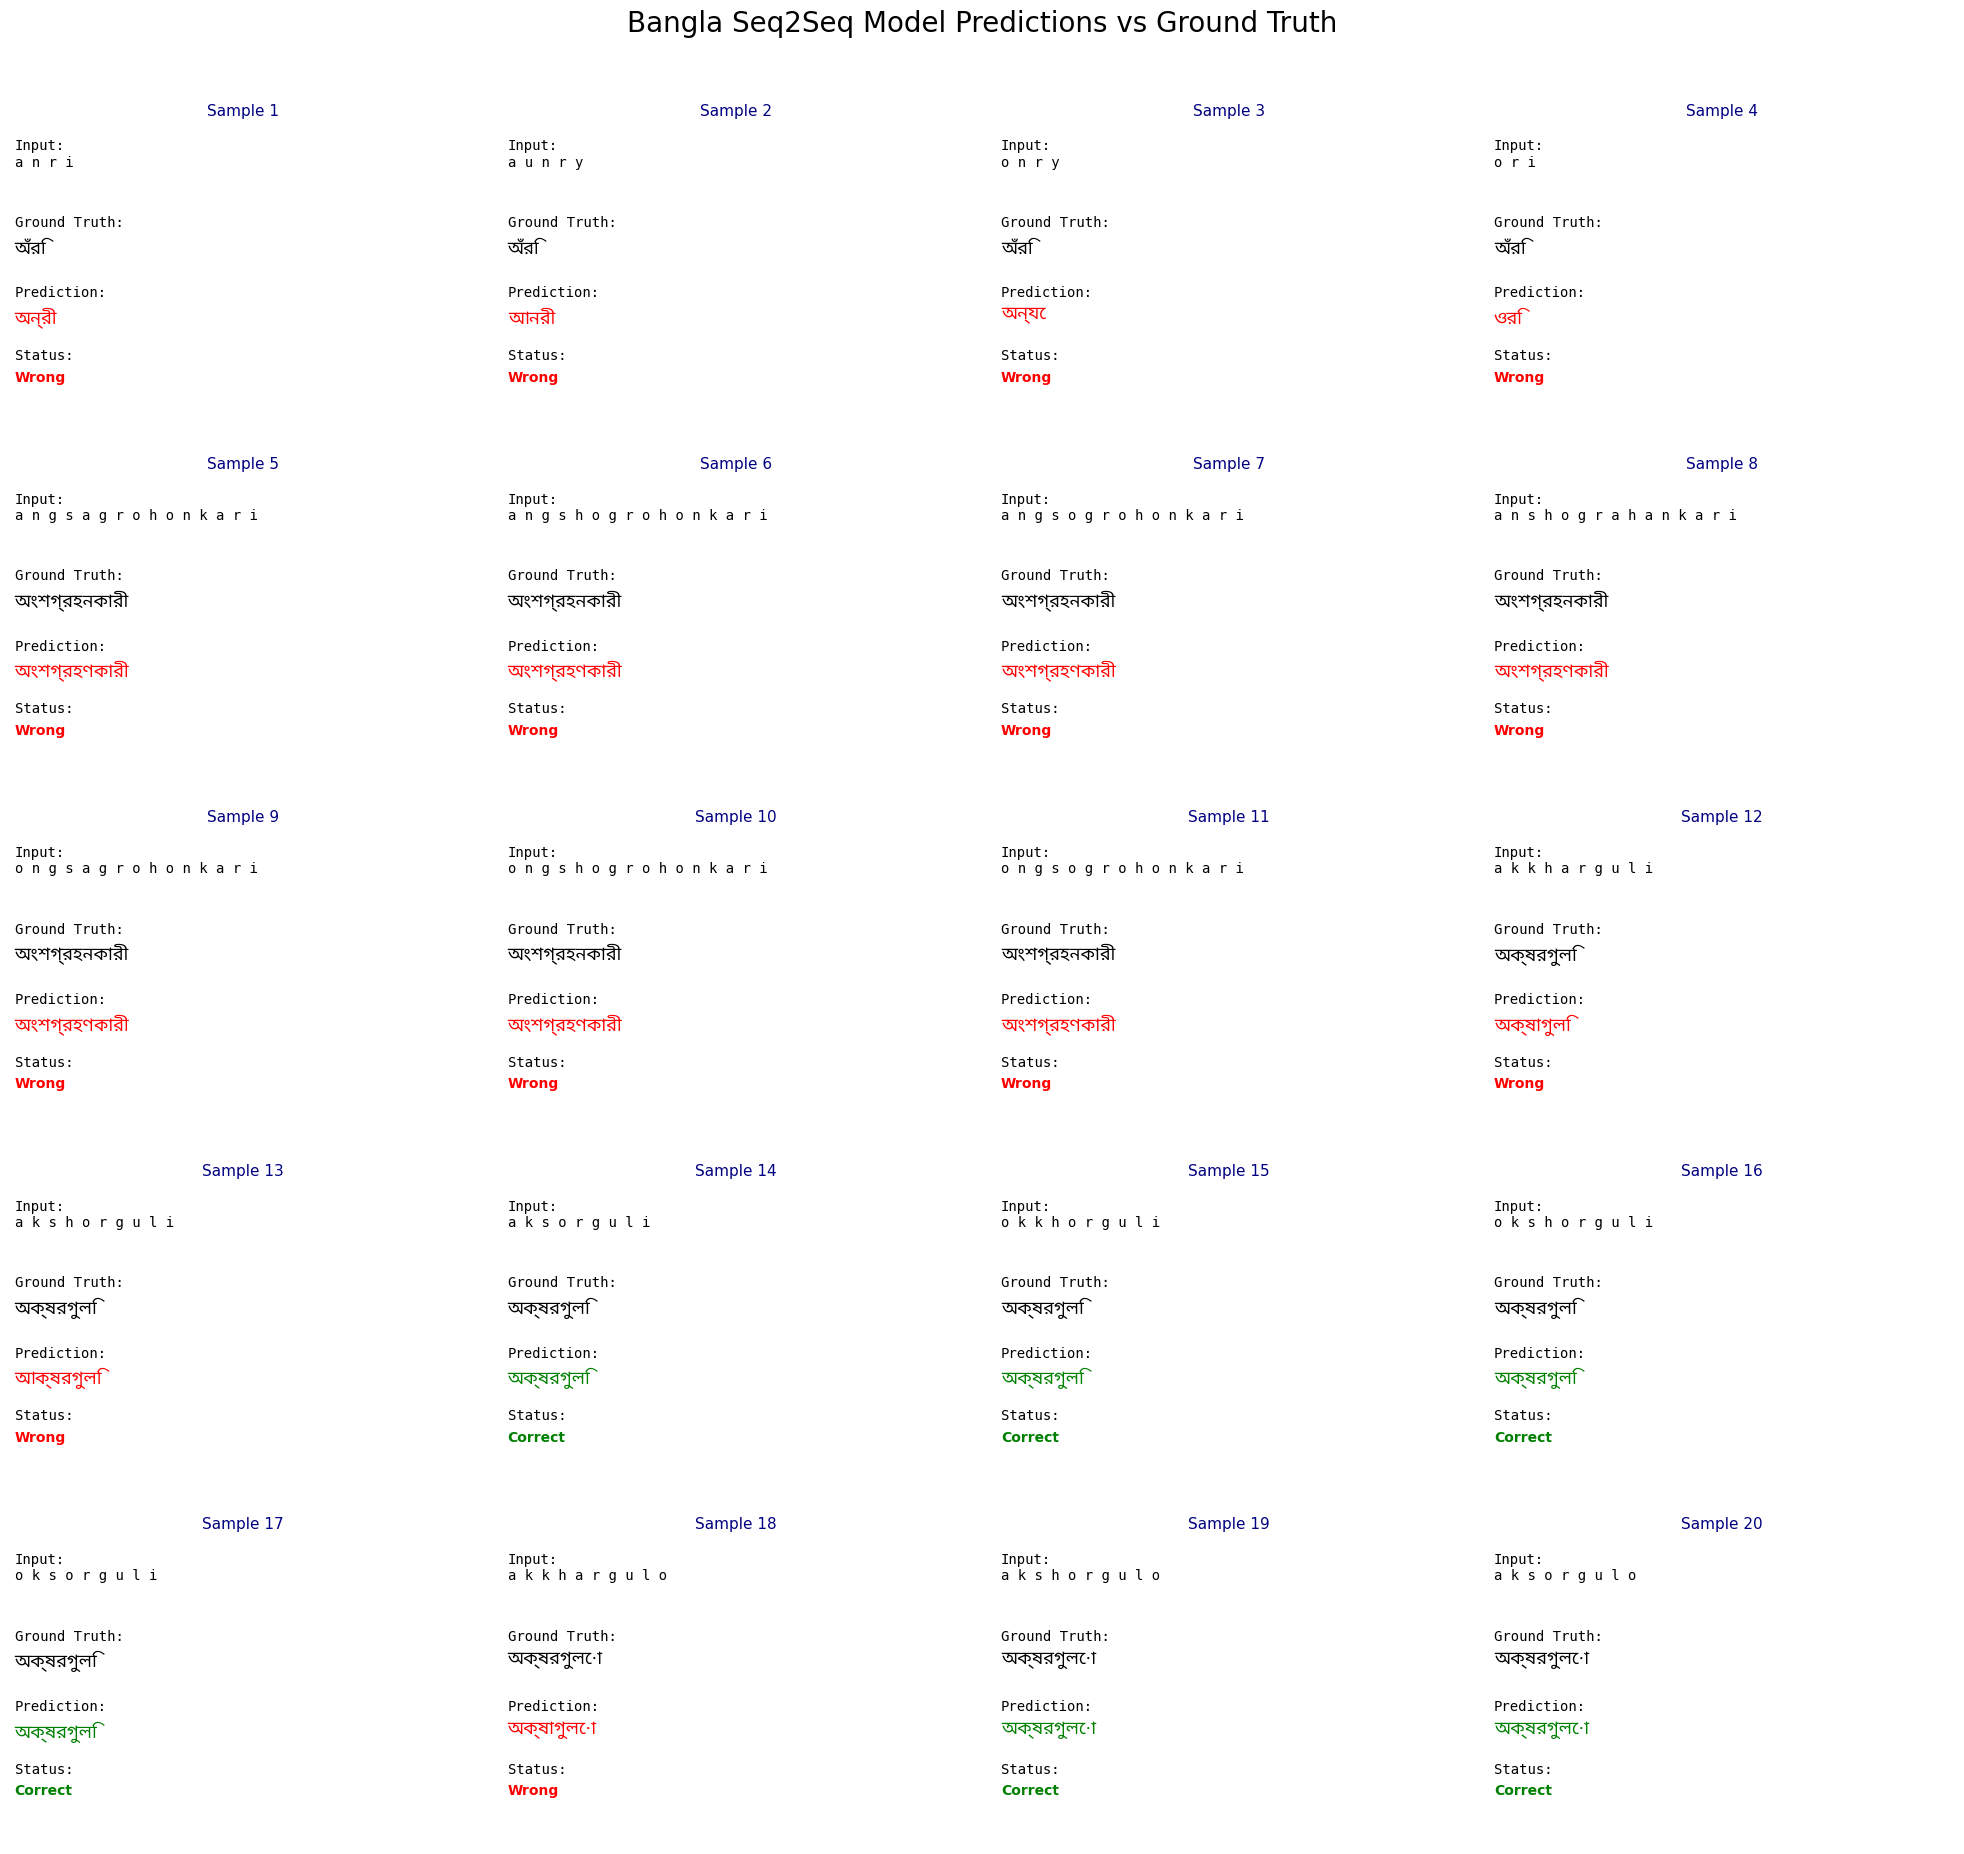

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [ ]:
"""
This code snippet initializes a Weights & Biases (wandb) project named "bangla-seq2seq-eval" to systematically track and log
the evaluation of a trained sequence-to-sequence (seq2seq) model. It then visualizes the model's predictions on a batch of
test data by displaying a grid of 20 sample inputs alongside their corresponding outputs. The visualization utilizes the
input and output vocabularies to decode sequences for interpretability, and the process is conducted on the specified
computation device (CPU or GPU). By setting `wandb_log=True`, the results and visualizations are automatically logged to
the wandb dashboard, facilitating easy monitoring and sharing of the model's performance. Finally, the wandb session is
gracefully closed to ensure all logs are properly saved.
"""
# Visualize predictions
wandb.init(project="bangla-seq2seq-eval")

visualize_predictions_grid(
    seq2seq_model=best_seq2seq,
    dataloader=test_dataloader,
    input_vocab=vocab_in,
    output_vocab=vocab_out,
    device=device,
    num_samples=20,
    wandb_log=True
)
wandb.finish()


In [ ]:

def export_predictions_to_file(seq2seq_model, dataloader, input_vocab, output_vocab, device, save_path='test_predictions.csv', show_preview=True):
    """
    This function evaluates a trained sequence-to-sequence (seq2seq) model on a given dataset and exports its predictions to a CSV file. 

    It performs the following key steps:
    - Converts input and output vocabulary dictionaries to index-to-token mappings for easier decoding.
    - Sets special token strings for padding (<pad>), start-of-sequence (<sos>), and end-of-sequence (<eos>).
    - Switches the model to evaluation mode and disables gradient computations to optimize inference speed.
    - Iterates through batches from the provided dataloader, moving input and target tensors to the specified device.
    - Generates predictions without teacher forcing by forwarding inputs through the seq2seq model.
    - Converts model output token indices back to readable sequences, filtering out special tokens.
    - Compares each predicted sequence to its ground truth target to mark predictions as correct or wrong.
    - Aggregates all results into a structured list of dictionaries, each containing the input sequence, ground truth, predicted output, and correctness status.
    - Writes these results into a CSV file at the specified path with appropriate headers.
    - Prints a confirmation message indicating successful export.

    This utility helps in qualitative and quantitative analysis of model performance by providing an easy-to-review file format, supporting debugging and reporting in sequence prediction tasks like machine translation, transliteration, or text summarization.

    Parameters:
    - seq2seq_model: The trained sequence-to-sequence model to be evaluated.
    - dataloader: A PyTorch DataLoader providing batches of input and target sequences.
    - input_vocab: Dictionary mapping input tokens to indices.
    - output_vocab: Dictionary mapping output tokens to indices.
    - device: The torch device (CPU or GPU) on which tensors should be processed.
    - save_path (str): File path to save the CSV with predictions (default: 'test_predictions.csv').
    - show_preview (bool): Optional flag to enable previewing results (not used in current code).

    Returns:
    None
    """
    
    idx2input = {v: k for k, v in input_vocab.items()}
    idx2output = {v: k for k, v in output_vocab.items()}

    PAD = "<pad>"
    EOS = "<eos>"
    SOS = "<sos>"

    all_data = []

    seq2seq_model.eval()
    with torch.no_grad():
        for input_batch, target_batch in dataloader:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            output = seq2seq_model(input_batch, target_batch, teacher_force_ratio=0)
            _, predicted = torch.max(output, dim=2)

            for i in range(input_batch.size(0)):
                src_seq = [idx2input[token.item()] for token in input_batch[i] if token.item() != input_vocab[PAD]]
                tgt_seq = [idx2output[token.item()] for token in target_batch[i] if token.item() not in [output_vocab[PAD], output_vocab[EOS], output_vocab[SOS]]]
                pred_seq = [idx2output[token.item()] for token in predicted[i] if token.item() not in [output_vocab[PAD], output_vocab[EOS], output_vocab[SOS]]]

                is_correct = pred_seq == tgt_seq
                status = "Correct" if is_correct else "Wrong"

                all_data.append({
                    "Input Sequence": " ".join(src_seq),
                    "Ground Truth": "".join(tgt_seq),
                    "Prediction": "".join(pred_seq),
                    "Status": status
                })

    # Write to CSV
    with open(save_path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=["Input Sequence", "Ground Truth", "Prediction", "Status"])
        writer.writeheader()
        writer.writerows(all_data)

    print(f"\n Test predictions exported to: {save_path}")



In [ ]:
"""
This code snippet uses the trained sequence-to-sequence (seq2seq) model `best_seq2seq` to generate predictions on 
the data provided by `test_dataloader`. It leverages the input and output vocabularies (`vocab_in` and `vocab_out`) 
to correctly interpret and decode sequences during inference. The model runs on the specified computation `device` 
(e.g., CPU or GPU) to optimize performance. The resulting predictions are then exported and saved into a CSV file 
named "test_predictions_without_attention.csv". This organized output facilitates subsequent evaluation, 
analysis, or submission of the model's performance on unseen test data.
"""
# Use your best model and test dataloader
export_predictions_to_file(best_seq2seq, test_dataloader, vocab_in, vocab_out, device, save_path="test_predictions_without_attention.csv")



 Test predictions exported to: test_predictions_without_attention.csv
